<a href="https://colab.research.google.com/github/AriyanaC/Internship-project--IDEAS-Institute-of-Data-Engineering-Analytics-and-Science-Foundation-ISI-Kolkata/blob/main/Copy_of_04_fake_news_detection_and_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project Name: Fake News Detection and Evaluation with Confusion Matrix**
####**created by: Suprava Das**

# **Problem Statement:**


This project addresses the challenge of distinguishing fake news from true news using machine learning techniques. A classification model is trained on textual data, and its effectiveness is evaluated through a confusion matrix to assess accuracy and misclassification patterns.

# **Data Introduction:**

This dataset was compiled from real-world sources; the genuine articles were scraped from Reuters.com (a reputable news website). In contrast, the fake news articles were gathered from various unreliable platforms identified by Politifact (a U.S.-based fact-checking organization) and Wikipedia. The collection covers articles on diverse subjects, though most of them center around politics and world news.

The dataset cab also be downloaded from kaggle using the link: www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets

# **Import Packages**

Imported all required libraries and installed any missing packages in Google Colab.

In [5]:
pip install gensim

In [6]:
# import necessary packages
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string
from sklearn.model_selection import train_test_split
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# mounted the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Data Preprocessing**

In [8]:
# read the csv file using pandas dataframe
fake_news_data = pd.read_csv('/content/fake.csv')
true_news_data = pd.read_csv('/content/true.csv')

**Q1.** View the imported csv file data using Pandas Dataframe.

In [9]:
display(fake_news_data.head())
display(true_news_data.head())

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [10]:
fake_news_data["class"] = 1  # Fake News data → 1
true_news_data["class"] = 0  # True News data → 0

In [11]:
# merged true and fake news datasets
merged_data = [fake_news_data,true_news_data]
df = pd.concat(merged_data,axis=0)

**Q2.** drop rows from the dataset consisting null values.

In [12]:
df = df.dropna()

**Q3.** shuffle the data.

In [13]:
df = df.sample(frac=1)

In [14]:
#reset index of the merged dataframe
df = df.reset_index(drop=True)

In [15]:
# view top 10 rows of processed dataset
df.head(10)

,title,text,subject,date,class
0,GRAVE DIGGING PROTESTERS Start to Dig Up Confe...,THIS HAPPENED IN 2015 BUT IS STILL RELEVANT TO...,left-news,"Aug 16, 2017",1
1,Candidate Handel’s Excellent Response to Alexa...,We should not allow our political differences...,left-news,"Jun 14, 2017",1
2,UNHOLY ALLIANCE: Hillary Clinton’s Saudi Spons...,21st Century Wire says Amid the tossing and t...,US_News,"August 26, 2016",1
3,House Speaker Ryan says contested Republican c...,WASHINGTON (Reuters) - House Speaker Paul Ryan...,politicsNews,"March 17, 2016",0
4,Factbox: First 100 days of Trump on Twitter,(Reuters) - President Donald Trump has cemente...,politicsNews,"April 28, 2017",0
5,U.S. poised to approve Boeing fighter jet sale...,WASHINGTON (Reuters) - The U.S. government is ...,politicsNews,"April 18, 2016",0
6,"Clinton, Sanders agree to a April 14 debate: CNN",(Reuters) - U.S. Democratic presidential candi...,politicsNews,"April 4, 2016",0
7,Californians seek pot of gold in marijuana leg...,"SACRAMENTO, Calif. - There is no guarantee Cal...",politicsNews,"July 3, 2016",0
8,"Trump slow to implement Russia, Iran, North Ko...",WASHINGTON (Reuters) - Two months after signin...,politicsNews,"September 29, 2017",0
9,Republicans Alarmed As Wisconsin’s Racist Vot...,"Ever since the 2008 election, Republicans have...",News,"April 9, 2016",1


**Q4.** view the text content of a random data point.

In [16]:
random_row = df.sample(n=1)
random_text_content = random_row.iloc[0]["text"]
print(random_text_content)

 Who is silencing political speech, physically attacking those with divergent views, demanding that every American share one single  ideology. But sadly, the real truth is that these violent agitators have little idea about why they march. Theirs is a movement with no cause, a temper tantrum with no purpose. They are a generation lost in space .a propaganda arm of the party of disappointment. If I were wrong, would Hillary Clinton really be their standard bearer? These rioters are being manipulated by big government forces who need them to regain political power 


**Data Visualization**

Text(0, 0.5, 'Number of News')

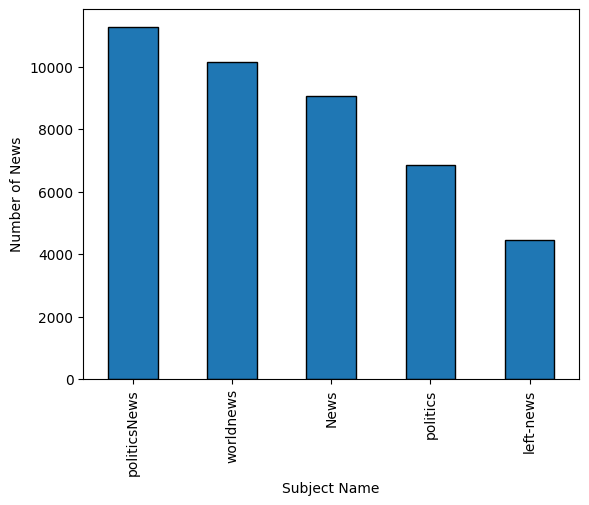

In [17]:
#create a data visualzation of bar/column/line chart of top 5 subjects ->
top_5_subjects = (df['subject'].value_counts()).nlargest(5)
top_5_subjects.plot(kind='bar', edgecolor='black', stacked=True)
plt.xlabel('Subject Name')
plt.ylabel('Number of News')

**Q5.** Create a pie chart to find the percentage of news on different subject.

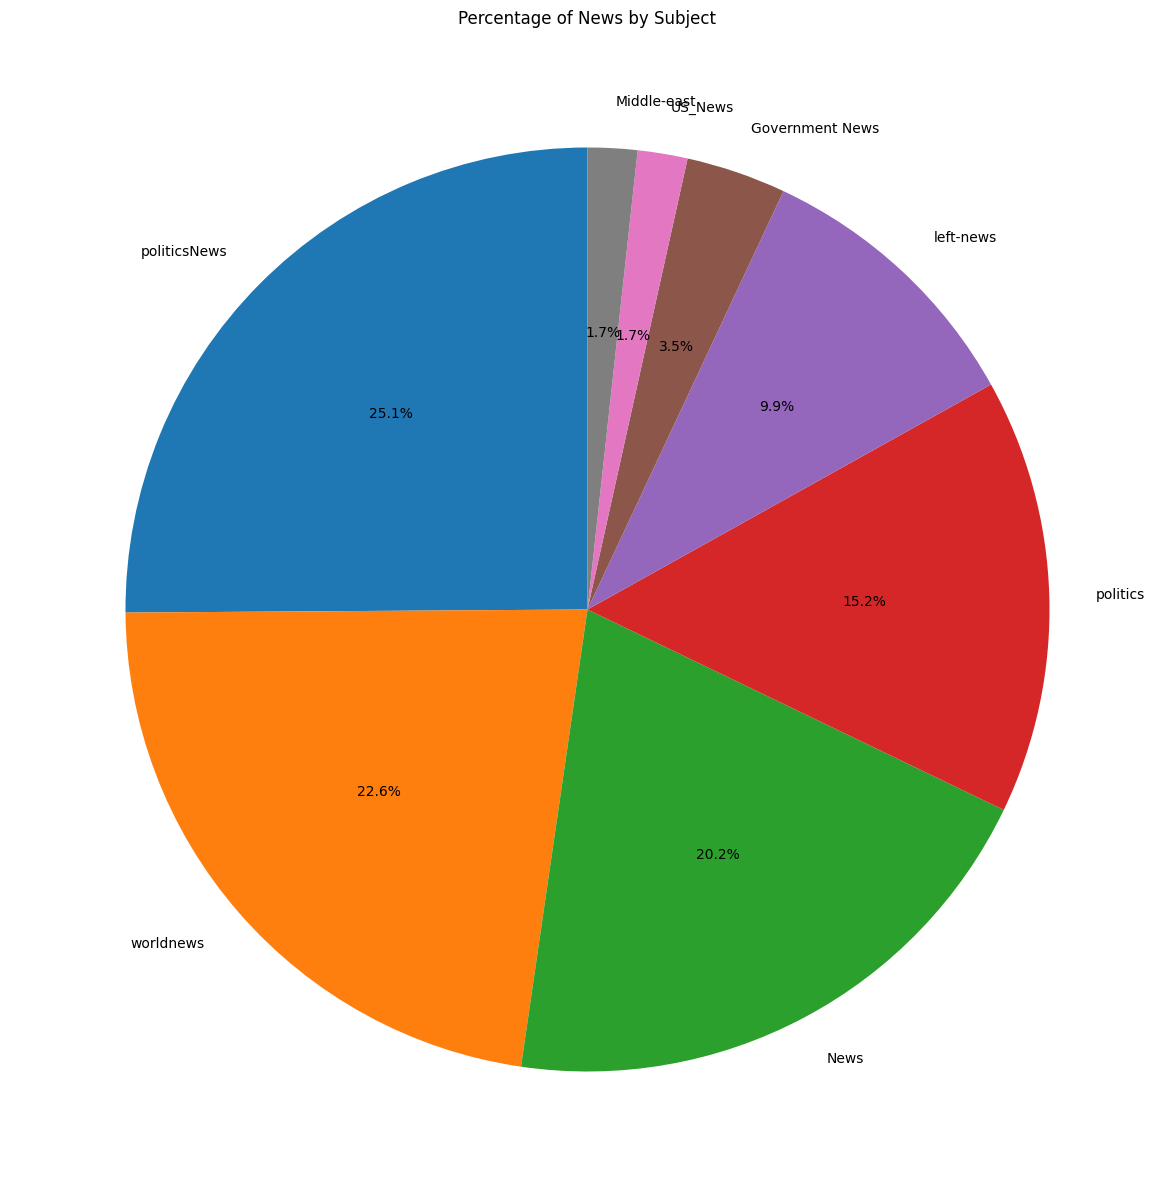

In [20]:
plt.figure(figsize=(15,15))
df['subject'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Percentage of News by Subject')
plt.ylabel('')
plt.show()

**Text Processing**

In [21]:
# function to remove space,special charecter and convert all text into lower case
def wordopt(text):
  text = text.lower()
  text= re.sub(r'https://\S+|www\.\S+','',text) # remove https:// or www.com
  text = re.sub(r'[^\w]',' ', text) #remove special charecter
  text= re.sub(r'\s+',' ',text) #remove multiple space

  return text

In [22]:
# drop unnecessary columns for classification purpose
df1= df.drop(['title','subject','date'],axis=1)

In [23]:
# apply wordopt method to the whole dataset and view the text content of a random data point
df1['text']=df1['text'].apply(wordopt)
df1['text'][100]

'fournier totally hammers these two great to see '

# **Building Model**

In [24]:
# Separate independent and target columns from the dataset and stored them in x & y variables
x= df1['text']
y= df1['class']

**Q6.** Split the dataset into training and testing sets with 25% test size and store them in x_train, x_test, y_train, and y_test.

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

## **Word Embedding ( Word2Vec )**

In [26]:
# import bbc_news data using url link in json format for training Word2Vec word embedding model
news = pd.read_json('https://query.data.world/s/7c6p2lxb3wjibfsfbp4mwy7p7y4y2d?dws=00000')
news_seg = news['content']
print("Size of Word Dictonary for training Word2Vec: ",news_seg.shape[0])
news_seg.head(2)

Size of Word Dictonary for training Word2Vec:  15825


,content
0,The heroin substitute methadone can be used as...
1,The eldest son of North Korean leader Kim Jong...


In [27]:
# apply wordopt function for text processing
news_seg=news_seg.apply(wordopt)
sentences = [sentence.split() for sentence in news_seg ]
w2v_model = Word2Vec(sentences,  window=5, min_count=5, workers=4)

In [28]:
# function to convert a sentence into vector form
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [29]:
# convert train and test dataset into vector form
xv_train = np.array([vectorize(sentence) for sentence in x_train])
xv_test = np.array([vectorize(sentence) for sentence in x_test])

##**Logistic Regression**

In [30]:
# Trains a Logistic Regression model using vector formed trained data ->
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(xv_train,y_train)

LogisticRegression()

In [31]:
# detect the class(fake or true) on test data and evaluates its accuracy on test set
y_pred = logistic_model.predict(xv_test)
print("Prediction on test data: ",y_pred)
print("Accuracy Score on Test Data: ",logistic_model.score(xv_test,y_test))

Prediction on test data:  [0 1 1 ... 0 0 0]
Accuracy Score on Test Data:  0.94271714922049


####**Accuracy Checking**

In [32]:
# Check Precision, Recall, F1 Score of the logistic model ->
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred))

Accuracy: 0.94271714922049
Precision: 0.9505709902846429
Recall: 0.9404721753794266
F1 score: 0.9454946172755785


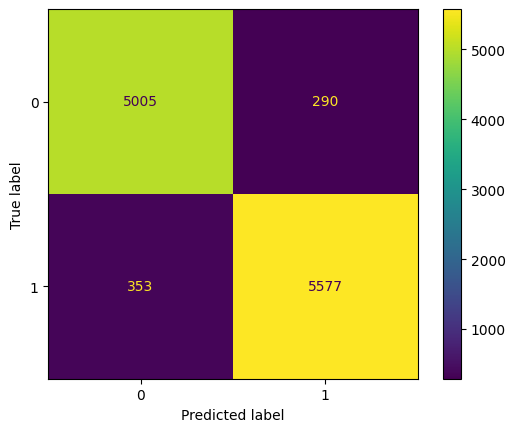

In [33]:
# Check overall accuracy using confusion matrix
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm= confusion_matrix(y_test,y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

##**Random Forest Classifier**

####**Model Building and Prediction**

**Q7.** Use Random Forest Classifer for this classfication purpose and predict the outcomes for test data.

In [34]:
from sklearn.ensemble import RandomForestClassifier
#Initialise and train the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(xv_train,y_train)

#Predict on the test data
y_pred_rf = rf_model.predict(xv_test)
print("Prediction on test data using Random Forest:", y_pred_rf)

Prediction on test data using Random Forest: [0 1 1 ... 0 0 0]


####**Accuracy Checking**

**Q8.** Find the accuracy, precison, recall, F1 Score of the model while using Random Forest Classsifier and visualize overall accuracy using confusion matrix.

--- Random Forest Model Evaluation (Corrected) ---
Accuracy: 0.9430734966592428
Precision: 0.949685534591195
Recall: 0.942158516020236
F1 score: 0.9459070515533734


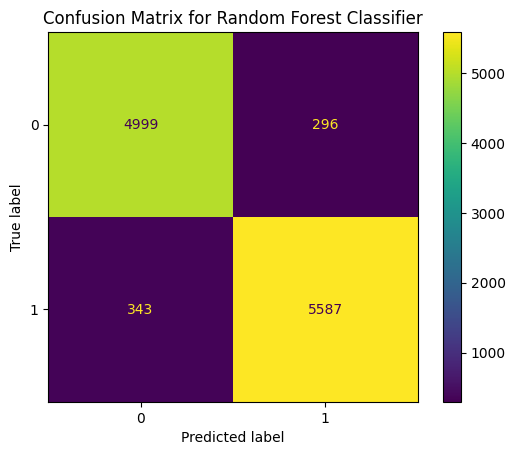

In [40]:
#Check Precision, Recall, F1 score of the Random Forest model
print("--- Random Forest Model Evaluation (Corrected) ---")
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))
print('F1 score:', f1_score(y_test, y_pred_rf))

#check overall accuracy using confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test,y_pred_rf)
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix = cm_rf)
cm_display_rf.plot()
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()

#**Save the Model using pickle**

In [36]:
# save the logistic regression model as pickle file
import pickle
filename1 = '/content/drive/My Drive/IDEAS-TIH/Internship_2025/word2vec_logistic_model.pickle'
pickle.dump(logistic_model, open(filename1, 'wb')) #word2vec model

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/IDEAS-TIH/Internship_2025/word2vec_logistic_model.pickle'

In [ ]:
# Load the pickle file and checkout model score
loaded_model = pickle.load(open(filename1, 'rb'))
result = loaded_model.score(xv_test, y_test)
print(result)

**Q9.** Save the trained Random Forest Model as pickle/svg file in your desired repository for further use.

In [ ]:
#Save the Random Forest model as a pickle file
filename2 = '/content/drive/my Drive/IDEAS-TIH/Internship_2025/word2vec_random_forest_model.pickle'
pickle.dump(rf_model, open(filename2, "wb"))

**Q10.** Load that saved model in another Notebook. Use it on other dataset for fake news detection.

In [ ]:
# To mount the Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Defines the wordopt function again for text processing on the new data
def wordopt(text):
  text = text.lower()
  text= re.sub(r'https://\S+|www\.\S+','',text) # removes https:// or www.com
  text = re.sub(r'[^\w]',' ', text) #removes special characters
  text= re.sub(r'\s+',' ',text) #removes multiple spaces
  return text

# import bbc_news data using url link in json format for training Word2Vec word embedding model
news = pd.read_json('https://query.data.world/s/7c6p2lxb3wjibfsfbp4mwy7p7y4y2d?dws=00000')
news_seg = news['content']
print("Size of Word Dictonary for training Word2Vec: ",news_seg.shape[0])
news_seg.head(2)

# Define the vectorize function again to convert sentences to vectors
def vectorize(sentence):
    words = sentence.split()
    if 'w2v_model' not in globals():
        print("Word2Vec model not found. Please load or train the model.")
        return np.zeros(100) # Return a zero vector if model is not available

    words_vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

filename2 = '/content/drive/My Drive/IDEAS-TIH/Internship_2025/word2vec_random_forest_model.pickle'
loaded_rf_model = pickle.load(open(filename2, "rb"))

new_fake_news_data = pd.read_csv('/content/drive/My Drive/IDEAS-TIH/Internship_2025/Fake.csv')

# Apply the wordopt function to the new dataset
new_fake_news_data['text'] = new_fake_news_data['text'].apply(wordopt)

# Convert the text data in the new dataset to vector form using the same vectorize function
xv_new_data = np.array([vectorize(sentence) for sentence in new_fake_news_data['text']])

# Predict the class (fake or true) on the new data
predictions = loaded_rf_model.predict(xv_new_data)

# Add the predictions as a new column to your new dataset
new_fake_news_data['predicted_class'] = predictions

# Display the new dataset with predictions
display(new_fake_news_data.head())

print("Predicted class distribution on new data:")
print(new_fake_news_data['predicted_class'].value_counts())


**Q11(Optional).**


1.  Try to enhance the model's accuracy by using adaboost or any other boosting methods.
2.  Use TF-IDF or any other vectorizer instead of Word2Vec and study how much it affects on model's accuracy.




